In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# Welcome here!!!

**Lets get all the images from the dataset and store the paths as well as their labels**

In [2]:
img_paths=[]
img_labels=[]
for i in glob('../input/satellite-images-of-hurricane-damage/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])

In [3]:
len(img_paths),len(img_labels)

(23000, 23000)

In [4]:
print('We got total '+str(len(img_paths))+' images')

We got total 23000 images


**Saving the image paths and their labels into dataframe**

In [5]:
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
17247,../input/satellite-images-of-hurricane-damage/test_another/damage/-95.63271800000001_29.84605.jpeg,damage
1216,../input/satellite-images-of-hurricane-damage/train_another/damage/-95.08227099999999_29.828746999999996.jpeg,damage
22567,../input/satellite-images-of-hurricane-damage/test/no_damage/-95.093926_30.085128000000005.jpeg,no_damage
8911,../input/satellite-images-of-hurricane-damage/train_another/no_damage/-95.630044_29.859894.jpeg,no_damage
9799,../input/satellite-images-of-hurricane-damage/train_another/no_damage/-95.669907_29.810515999999996.jpeg,no_damage


<AxesSubplot:xlabel='1', ylabel='count'>

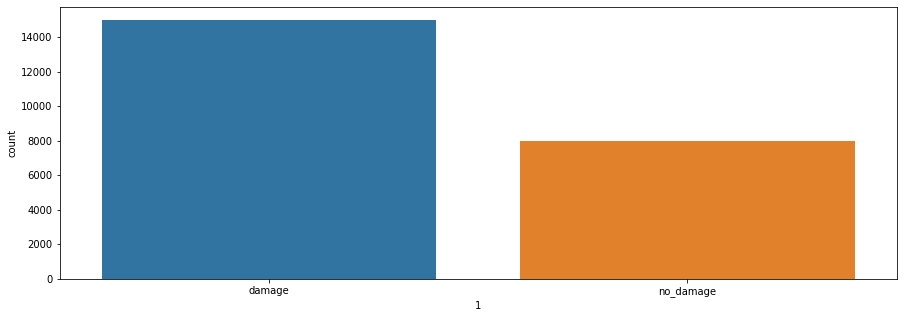

In [6]:
plt.figure(figsize=(15,5))
sns.countplot(x=data[1])

> It seems the number of no damage is half than actual damage image.

In [7]:
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(data,test_size=0.25,random_state=0)
train_set.shape,test_set.shape

((17250, 2), (5750, 2))

> Splitted the dataset into training and testing sets

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [9]:
train_gen = ImageDataGenerator(validation_split=0.1,rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)
test_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)

train_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    batch_size=100,
    seed=2020
)

val_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    batch_size=100,
    seed=2020
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=100,
    seed=2020
)

Found 15525 validated image filenames belonging to 2 classes.
Found 1725 validated image filenames belonging to 2 classes.
Found 5750 validated image filenames belonging to 2 classes.


> Getting the Traininig, Validation & Testing images

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)


> Model creation & compilation

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [12]:
history = model.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
156/156 [==============================] - 1205s 8s/step - loss: 1.1505 - accuracy: 0.5796 - recall: 0.5718 - val_loss: 0.5999 - val_accuracy: 0.6864 - val_recall: 0.6835
Epoch 2/15
156/156 [==============================] - 1195s 8s/step - loss: 0.9604 - accuracy: 0.6679 - recall: 0.6393 - val_loss: 0.5319 - val_accuracy: 0.7246 - val_recall: 0.7003
Epoch 3/15
156/156 [==============================] - 1184s 8s/step - loss: 0.8492 - accuracy: 0.7093 - recall: 0.6791 - val_loss: 0.4911 - val_accuracy: 0.7751 - val_recall: 0.7704
Epoch 4/15
156/156 [==============================] - 1182s 8s/step - loss: 0.7753 - accuracy: 0.7386 - recall: 0.7045 - val_loss: 0.4795 - val_accuracy: 0.7814 - val_recall: 0.7826
Epoch 5/15
156/156 [==============================] - 1198s 8s/step - loss: 0.7105 - accuracy: 0.7622 - recall: 0.7319 - val_loss: 0.4589 - val_accuracy: 0.8064 - val_recall: 0.8070
Epoch 6/15
156/156 [==============================] - 1195s 8s/step - loss: 0.6644 - accur

> Model Training

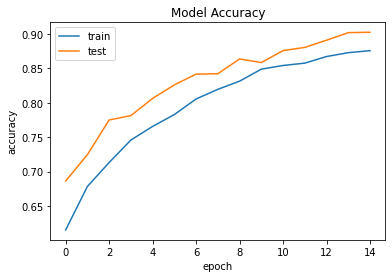

In [13]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

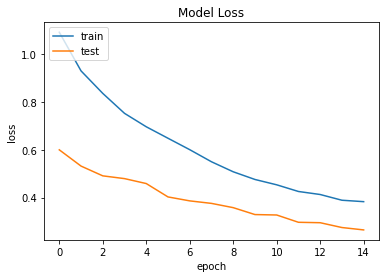

In [14]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred,axis=1)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3739
           1       0.88      0.82      0.85      2011

    accuracy                           0.90      5750
   macro avg       0.90      0.88      0.89      5750
weighted avg       0.90      0.90      0.90      5750



In [17]:
classes=['Damage','No Damage']
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred),
                     index = classes, 
                     columns = classes)

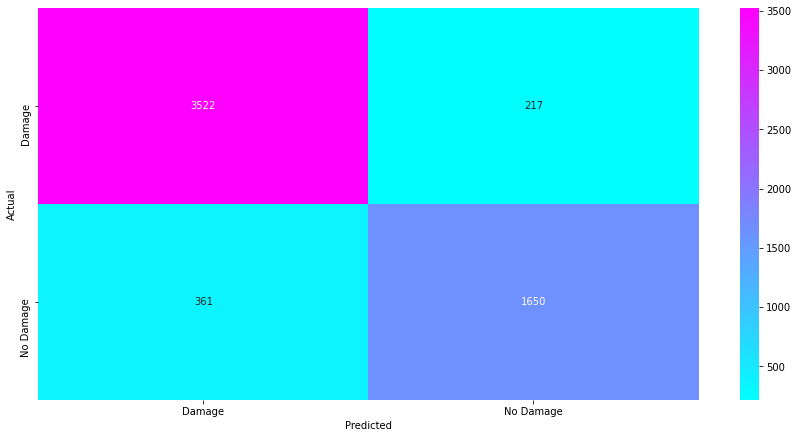

In [18]:
import seaborn as sns
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
model.save('initial_model.h5')